# Image Captioning

Automatic Image Caption Generation using CNN-RNN Architecture and Caching for faster Model Training.

*   Dataset: Flickr8k
*   Feature Extraction is done using **InceptionNetV3**.
*   RNN-Decoder Model is taken from TensorFlow Tutorials.

### Imports

Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
import os
import random
import ast
import scipy
import pandas as pd
from pickle import dump, load
from tqdm.auto import tqdm
import keras
import random
import string
import cv2,re
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Concatenate, GRU, Embedding
from tensorflow.keras.applications.inception_v3 import InceptionV3

Connecting to Google Drive

In [23]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Learning and Developing/Datasets/Flickr_Data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Learning and Developing/Datasets/Flickr_Data


### Importing Images and Captions

List of Available Images

In [3]:
base_dir = os.getcwd()
os.chdir(base_dir+'/Images')
Available_Images = os.listdir()
os.chdir(base_dir)

Captions

In [4]:
filename = 'Flickr_TextData/Flickr8k.token.txt'
file = open(filename,'r')
Data = file.read()

### Loading and Preprocessing Data

#### PreProcessing Captions

In [5]:
def PreprocessingCaptions(text):
    
    # Removing Punctions
    translator = str.maketrans('', '', string.punctuation)
    text.translate(translator)

    # Converting in Lower Characters
    text = re.sub("[^a-zA-Z]"," ",text)
    text = [word.lower() for word in text.split()]

    # Removing Hanging Letters
    text = [word for word in text if len(word)>1]
    
    text = " ".join(text)
    
    return text

#### Function to Create a Map Between Images and Captions

Creating a Map between Images and their Captions

In [6]:
def LoadData(data,Available_Images):
    Image2Caption = {}

    MaxLength = 0

    for line in data.split('\n'):
        l = line.split()
        if len(l) < 2:
            continue
        ImageName, Caption = l[0], l[1:]
        ImageName = ImageName.split('#')[0]

        if  ImageName in Available_Images:
            Caption = ' '.join(Caption)
            Caption = '<startsqn> ' + PreprocessingCaptions(Caption) + ' <endsqn>'

            length = len(Caption.split())
            MaxLength = max(MaxLength,length)

            if ImageName not in Image2Caption:
                Image2Caption[ImageName] = []

            Image2Caption[ImageName].append(Caption)

    return Image2Caption,MaxLength

Image2Caption,MaxLength = LoadData(Data,Available_Images)

Datasets

In [7]:
import time

def CreateData(Available_Images,Image2Caption):
    X = []
    y = []

    for key,value in Image2Caption.items():
        if key in Available_Images:
            X = X + [key]
            y = y + [value]
            i = 10
    
    return X,y

ImageData, CaptionData = CreateData(Available_Images,Image2Caption)

### InceptionNetV3

We will use InceptionNetV3 to get fixed-length informative vector for each image. This process is called Automatic Feature Engineering.


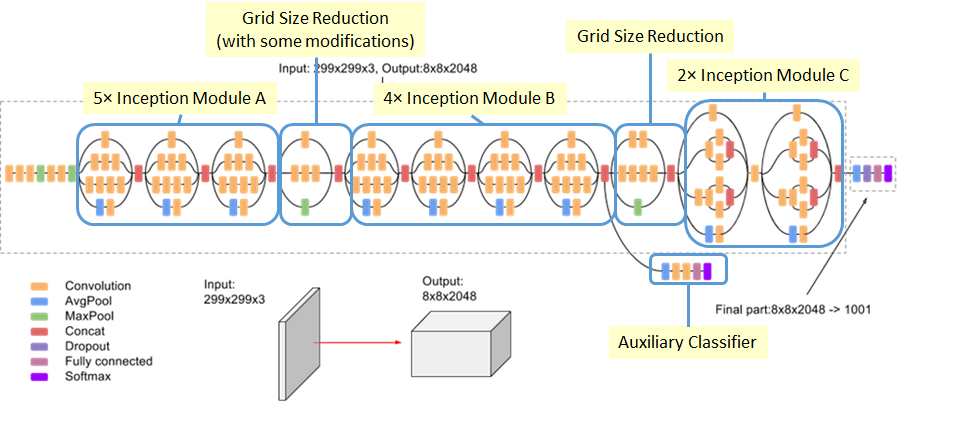



In [8]:
model = InceptionV3(weights='imagenet')
FeatureExtractionModel = Model(model.input, model.layers[-3].output)
_ = plot_model(FeatureExtractionModel, to_file='Feature_Extraction_Part_of_InceptionNetV3.png')

### Preprocessing and Encoding Image Data

Feature Extraction of Image using InceptionNetV3

In [9]:
def ExtractFeatures(X):
    img = FeatureExtractionModel.predict(X)
    img = np.reshape(img,(-1,64,2048))
    return img

### Tokenizing Text Data

In [10]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
Tokenizer.fit_on_texts(np.array(CaptionData).flatten())

Tokenizer.word_index['<pad>'] = 0
Tokenizer.index_word[0] = '<pad>'

In [11]:
CaptionTokens = np.array(CaptionData).flatten()
CaptionTokens = tf.keras.preprocessing.sequence.pad_sequences(Tokenizer.texts_to_sequences(CaptionTokens), maxlen = MaxLength,padding='post')
CaptionTokens = np.reshape(CaptionTokens, (-1,5,35))

### Data Generator

Batch Size of Images

In [12]:
BatchSize = 64

#### **Caching**

Caching is done due to Computations insufficiencies. Caching all the Features of Images with the accoring to their Batch Size, decrease the time taken for training the Model by aleast 50 times.

```
def Caching(ImageData,BatchSize):
    X = []
 
    for i in range(len(ImageData)):
 
        img = resize(imread('Images/' + ImageData[i]),(299,299,3))
        X.append(img)
 
        if (i+1)%BatchSize == 0 or (i+1) == len(ImageData):
            X = np.array(X)
            print (X.shape)
            X = ExtractFeatures(X)
            if ((i+1)%BatchSize == 0):
                filename = 'Cache/' + str(int((i+1)/BatchSize)) + '.npy'
            else:
                filename = 'Cache/' + str(int((i+1)/BatchSize) + 1) + '.npy'
                
            np.save(filename, X)
            print ("Saved " + filename)
            X = []
 
Caching(ImageData,BatchSize)
```



#### Data Generator

In [13]:
class DataGenerator():

    def __init__(self, Image, Caption, batch_size):
        self.Image = Image
        self.Caption = Caption
        self.batch_size = batch_size
    
    def getBatch(self, idx):

        filename = 'Cache/' + str(idx+1) + '.npy'
        X = np.load(filename)
        l = X.shape[0]
        y = self.Caption[idx*self.batch_size: idx*self.batch_size + l]

        X = np.repeat(X, 5, axis=0)
        y = np.reshape(y,(-1,35))
        
        return X,y

Check Encoding 


```
DG = DataGenerator(ImageData,CaptionTokens,BatchSize)
X,y = DG.getBatch(10)

Real_Caption = ' '.join([Tokenizer.index_word[i] for i in CaptionTokens[640][2] if i not in [0]])
Encoded_Caption = ' '.join([Tokenizer.index_word[i] for i in y[2] if i not in [0]])
print (Encoded_Caption)
print ('Real Caption: ', Real_Caption)
plt.imshow(imread('Images/' + ImageData[640]))
plt.show()
```



### Encoder-Decoder Model

CNN-RNN Encoder Decoder with Bahdanau Attention

Source of Model: [TensorFlow Tutorials](https://www.tensorflow.org/tutorials/text/image_captioning)

In [12]:
tf.keras.backend.clear_session()

#### CNN Encoder

In [13]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = Dense(embedding_dim, activation='relu')

    def call(self, x):
        x = self.fc(x)
        return x

#### Bahdanau Attention

In [14]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    score = tf.nn.tanh(self.W1(features) + self.W2(tf.expand_dims(hidden, 1)))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

#### RNN Decoder

In [15]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

### Training Model

Training and Model Parameters

In [16]:
Embedding_Dims = 256
VocabSize = 5000
Units = 512
FeaturesShape = 2048
AttentionFeatures = 64
Epochs = 50

# Encoder
Encoder = CNN_Encoder(Embedding_Dims)

# Decoder
Decoder = RNN_Decoder(Embedding_Dims, Units, VocabSize)

Optimizer

In [21]:
Optimizer = tf.keras.optimizers.Adam()
LossObject = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

Total_Loss = 0

def LossFunction(real, pred):
  Mask = tf.math.logical_not(tf.math.equal(real, 0))
  Loss = LossObject(real, pred)
  Mask = tf.cast(Mask, dtype=Loss.dtype)

  Loss *= Mask

  return tf.reduce_mean(Loss)

Train Function

In [22]:
@tf.function
def train_step(X, y):
  Loss = 0
  Hidden = Decoder.reset_state(batch_size=y.shape[0])
  Decoder_Input = tf.expand_dims([Tokenizer.word_index['startsqn']] * y.shape[0], 1)

  with tf.GradientTape() as tape:
      Features = Encoder(X)

      for i in range(1, y.shape[1]):
          Predictions, Hidden, _ = Decoder(Decoder_Input, Features, Hidden)

          Loss += LossFunction(y[:, i], Predictions)
          Decoder_Input = tf.expand_dims(y[:, i], 1)

  Total_Loss = Loss / int(y.shape[1])

  trainable_variables = Encoder.trainable_variables + Decoder.trainable_variables
  gradients = tape.gradient(Loss, trainable_variables)

  Optimizer.apply_gradients(zip(gradients, trainable_variables))

  return Loss, Total_Loss

Training the Model

In [ ]:
DG = DataGenerator(ImageData,CaptionTokens,BatchSize)

LossData = []
Indexes = list(np.arange(int(len(ImageData) / BatchSize) + 1, dtype=np.int8))

In [ ]:
for i in range(Epochs):
    print('Epoch-' + str(i+1) + ':')
    random.shuffle(Indexes)
    TotalLossData = 0
    for j in tqdm(range(len(Indexes)), desc='Steps'):
        X,y = DG.getBatch(Indexes[j])
        TotalLossData += train_step(X, y)[1]

    LossData.append(TotalLossData/len(Indexes))
    print ('Loss after ' + 'Epoch-' + str(i) + ' : ' + str(LossData[i].numpy()))
    print()

In [ ]:
plt.plot(np.arange(Epochs),LossData)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('Loss-1.png')
plt.show()

In [ ]:
for i in range(int(Epochs/5)):
    print('Epoch-' + str(i) + ':')
    random.shuffle(Indexes)
    TotalLossData = 0
    for j in tqdm(range(len(Indexes)), desc='Steps'):
        X,y = DG.getBatch(Indexes[j])
        TotalLossData += train_step(X, y)[1]

    LossData.append(TotalLossData/len(Indexes))
    print ('Loss after ' + 'Epoch-' + str(i) + ' : ' + str(LossData[i].numpy()))
    print()

Plotting Loss

In [ ]:
plt.plot(np.arange(int(Epochs/5)),LossData)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('Loss-2.png')
plt.show()

Saving Models

In [ ]:
Encoder.save_weights('./Weights of Image Captioning/Encoder_Weights')
Decoder.save_weights("./Weights of Image Captioning/Decoder_Weights")

### Testing

Loading Models

In [17]:
Encoder.load_weights('./Weights of Image Captioning/Encoder_Weights')
Decoder.load_weights("./Weights of Image Captioning/Decoder_Weights")

In [18]:
def evaluate(image):

    Hidden = Decoder.reset_state(batch_size=1)

    Image_Input = tf.expand_dims(resize(imread(image),(299,299,3)), 0)
    Features = Encoder(ExtractFeatures(Image_Input))

    Decoder_Input = tf.expand_dims([Tokenizer.word_index['startsqn']], 0)
    result = []

    for i in range(MaxLength):
        Prediction, Hidden, _ = Decoder(Decoder_Input, Features, Hidden)
        Predicted_id = np.argmax(Prediction.numpy()[0])
        result.append(Tokenizer.index_word[Predicted_id])

        if Tokenizer.index_word[Predicted_id] == 'endsqn':
            return result

        Decoder_Input = tf.expand_dims([Predicted_id], 0)

    return result

Real Caption:  startsqn grey bearded scottish gentleman in red plaid is playing the bagpipes endsqn
Prediction Caption:  man with beard is playing the bagpipes endsqn


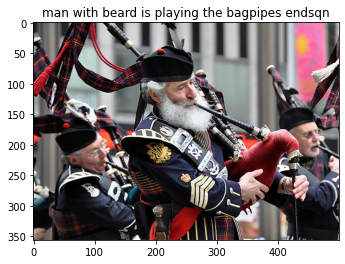

In [19]:
Index = random.randint(0,len(ImageData))

ImageName = 'Images/' + ImageData[Index]
Real_Caption = ' '.join([Tokenizer.index_word[i] for i in CaptionTokens[Index][0] if i not in [0]])
Prediction = evaluate(ImageName)

print ('Real Caption: ', Real_Caption)
print ('Prediction Caption: ', ' '.join(Prediction))
plt.title(' '.join(Prediction))
plt.imshow(imread(ImageName))
plt.show()

Prediction Caption:  young asian man with white hair and leather jacket endsqn


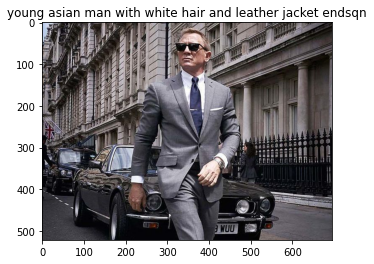

Prediction Caption:  dog running through the grassy field endsqn


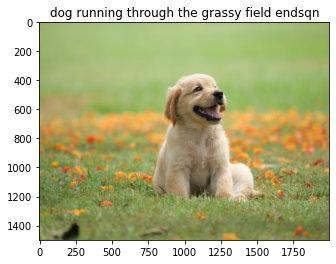

In [24]:
TestImages = os.listdir('TestImages')

ImageName = 'TestImages/' + TestImages[0]
Prediction = evaluate(ImageName)

print ('Prediction Caption: ', ' '.join(Prediction))
plt.title(' '.join(Prediction))
plt.imshow(imread(ImageName))
plt.show()



ImageName = 'TestImages/' + TestImages[1]
Prediction = evaluate(ImageName)

print ('Prediction Caption: ', ' '.join(Prediction))
plt.title(' '.join(Prediction))
plt.imshow(imread(ImageName))
plt.show()